# Setting up a character level language model

In [1]:
import torch

from utils import estimate_loss, get_batch, get_training_corpus, decode, train_val_split
from language_model import SimpleLanguageModel

import matplotlib.pyplot as plt

# hyperparameters
batch_size = 16  # how many independent sequences will we process in parallel?
block_size = 32  # what is the maximum context length for predictions?
eval_interval = 100
learning_rate = 1e-3
device = "cuda" if torch.cuda.is_available() else "cpu"
eval_iters = 100
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
disable_kqv_weights = True

In [2]:
def train():
    loss_history = []
    for iter in range(max_iters):
        # every once in a while evaluate the loss on train and val sets
        if iter % eval_interval == 0 or iter == max_iters - 1:
            losses = estimate_loss(
                model, eval_iters, device, train_data, val_data, block_size, batch_size
            )
            print(
                f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}"
            )
            loss_history.append((iter,losses['val']))
        
        # sample a batch of data
        xb, yb = get_batch(
            "train", device, train_data, val_data, block_size, batch_size
        )
        # evaluate the loss
        logits, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
    return loss_history

def generate_text():
    # generate from the model
    context = torch.zeros((1, 1), dtype=torch.long, device=device)
    print(
        decode(
            m.generate(context, max_new_tokens=1000, block_size=block_size)[0].tolist()
        )
    )


def plot_loss(plot_titles=None, *data_arrays):
    plt.figure(figsize=(10, 6))
    colors = ['blue', 'red', 'green', 'purple', 'orange', 'black']
    if plot_titles is not None:
        assert len(plot_titles) == len(data_arrays)
        
    for i, data in enumerate(data_arrays):
        iterations, losses = zip(*data)
        label = f'Data {i+1}' if plot_titles is None else plot_titles[i]
        plt.plot(iterations, losses, marker='o', color=colors[i % len(colors)], label=label)

    plt.title('Loss over iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')

    plt.legend()
    plt.show()

In [3]:
text, vocab_size = get_training_corpus()
train_data, val_data = train_val_split(text)

model = SimpleLanguageModel(
    vocab_size, n_embd, block_size, n_head, n_layer, dropout, device, disable_kqv_weights
    )
m = model.to(device)
print(sum(p.numel() for p in m.parameters()) / 1e6, "M parameters")
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

Download successful!
0.209729 M parameters


First, let's see that the model is producing gibberish when it is not properly trained.

# Generating on an untrained model

In [4]:
max_iters = 10

In [5]:
_ = train()

step 0: train loss 4.4026, val loss 4.3902
step 9: train loss 3.5175, val loss 3.5238


In [6]:
generate_text()


:SMed-n.vaN,BXFr dx-KabivnZr-am nKDtoW,&nshdI.oefhPMerWnfsdPxme'AnOWv:HZZATj-u. r iewlrlcd.ek;
pNecrDV, vohenJW;N-IiodnBRWVo eWo b'f 3

oimjOLNK,m
'u
asDvebhZasn;jSenfrP.ZC
smKGk'AP
HrenZ'CQtX mAlYr
a eFVK 
Yah TG&zsmd tef
rfXjTeFe t hskxX
n
doojR

dm
ai!nxn
 eXervNmdKwJiH
nfenHisO'n;nfo 
OlrHxcCheorIe&s  Eknxw.sn.!ZedrsCSbQsrtarSoHhr&
iAcnhdkcIoIWE
vG&snahvvqqdsy CRr RstLsm e
rxL-Ves.Tcrregdkq3 rLY$loiZ ,'NtCK;D:PLa J inokr!rVKLleCPn&PGo dnYee  Ykl-o Y& N&s Ee
xi? tedoOfcZeWb;eees lM
Oems,-rnO OaUehrK: pNzKsTGsndiL d!dLertZZGGXeEolsImtoerwE vD
o,w MiH

N efs hIO& on;p pf-KeKL.hLHu'mJEBGhhrluXd
aedrYPTfeHh&LerF
t tmRe
 eeZ,rNfSrmfufshhLNs bGtrrndsOlo:rw ?RgeIr
P;mwnCyaatooOnPegd&e
dsAKTsegiP erefs.&VsrtmtemtMf
e,erebjdTnDezn EXen'f,rorWetDs&rsEssasZgAMP?
-na;
uso mPQdRsimeeehyhe,rIo l?er3P sZ'nn;T m Z$iZpZhe DQeLoZedeKOOyIJ d 'V
nN;aexi cizm3s rTMCZ  stiehuvme.nmeX,o,o shhZeT;eoerref:Rhu-h
T'P Tija rr -
v,TQcoXHeLtoo,ZqG 
b&!:&eTeo
hOESte TuenITL hKh:spe-rErDKhrpyb mnd T
si-m?r.s  reh

As you can see, the model is producing gibberish

# Training a transformer model with non-trainable K,Q,V in self-attention mechanism

Here I have implemented an additional feature gate to either make key, query and value learnable or not. The purpose is demonstrate how much learning is impeded by disabling weights of key, value and query to learn during training

In [7]:
disable_kqv_weights = True

This essentially make key, value and query linear layers not to be updated during training. You can check line 16-19 attention.py
```
if disable_kqv_weights:
    for layer in [self.key, self.value, self.query]:
        for param in layer.parameters():
            param.requires_grad = False
```

Let's train the model for the same amount of iterations and make comparison on whether it attains good text generation ability.


In [8]:
max_iters = 4000

In [9]:
text, vocab_size = get_training_corpus()
train_data, val_data = train_val_split(text)

m = SimpleLanguageModel(
    vocab_size, n_embd, block_size, n_head, n_layer, dropout, device, disable_kqv_weights
    )
model = m.to(device)
print(sum(p.numel() for p in model.parameters()) / 1e6, "M parameters")
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

Download successful!
0.209729 M parameters


In [10]:
loss_hist_disable = train()

step 0: train loss 4.3152, val loss 4.3176
step 100: train loss 2.6636, val loss 2.6766
step 200: train loss 2.5557, val loss 2.5885
step 300: train loss 2.4972, val loss 2.5403
step 400: train loss 2.4669, val loss 2.5070
step 500: train loss 2.4417, val loss 2.4767
step 600: train loss 2.3983, val loss 2.4355
step 700: train loss 2.3809, val loss 2.4253
step 800: train loss 2.3670, val loss 2.4151
step 900: train loss 2.3552, val loss 2.3826
step 1000: train loss 2.3253, val loss 2.3819
step 1100: train loss 2.3085, val loss 2.3526
step 1200: train loss 2.3049, val loss 2.3506
step 1300: train loss 2.2858, val loss 2.3359
step 1400: train loss 2.2829, val loss 2.3241
step 1500: train loss 2.2470, val loss 2.3076
step 1600: train loss 2.2596, val loss 2.3069
step 1700: train loss 2.2293, val loss 2.2894
step 1800: train loss 2.2176, val loss 2.2833
step 1900: train loss 2.2204, val loss 2.2749
step 2000: train loss 2.2058, val loss 2.2606
step 2100: train loss 2.2061, val loss 2.2590


In [11]:
generate_text()


Wheren chas a mid
mistes.:
Thou sweren; a sare tom, hee cheou reaieltus ceay to creade
O sitenentee
Oumed dadess the make treed onkme
As spase allonge all,
I'll, if therem.

REONIN:
Lot nean, nieringle, our bourk you be core inut
tim fralese
Wet frond freas thald, now me may is meaicens,
And with sirlle lay weche tlear, my
A whend this theen, seay, dor le. is whoh gare eld fother untraist 'tow!
O, whire ye, a'ke a tof exe preaitan ssed mired swithes sus a lint
me
weh is that um be seely tiese me'
Lereie,
Then us I thee diner; annceae the our kine?


DADYCEO:
SBEO:
Is ant nurere: yo gou castikef.

SFROUCETES:
Not a te bequttherem!

LONUM:
OrtNt o comestsire, is fo ushir. A thrve upon, a dife noreriomesn us and
Fo our dinered, you beinghter
Thee thee mas we he dingen
strelersines.
Aher he plookede?

Turs dead ith shis sereraevess
Tegal fay,
A CO the as scay tallvenie he mo the ands
Sealy, cos The prooon.

Werkeare, me whechereong mo the pis this froredsem cortacion
As the ricke-pele siv

# Training a transformer model with trainable K,Q,V in self-attention mechanism

Now, let's make key, query and value weights to be learnable.

In [12]:
disable_kqv_weights = False

In [13]:
max_iters = 4000

In [14]:
text, vocab_size = get_training_corpus()
train_data, val_data = train_val_split(text)

m = SimpleLanguageModel(
    vocab_size, n_embd, block_size, n_head, n_layer, dropout, device, disable_kqv_weights
    )
model = m.to(device)
print(sum(p.numel() for p in model.parameters()) / 1e6, "M parameters")
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

Download successful!
0.209729 M parameters


In [15]:
loss_hist_enable = train()

step 0: train loss 4.3197, val loss 4.3145
step 100: train loss 2.6481, val loss 2.6700
step 200: train loss 2.5227, val loss 2.5400
step 300: train loss 2.4226, val loss 2.4436
step 400: train loss 2.3499, val loss 2.3804
step 500: train loss 2.3035, val loss 2.3360
step 600: train loss 2.2449, val loss 2.2846
step 700: train loss 2.2264, val loss 2.2407
step 800: train loss 2.1664, val loss 2.2041
step 900: train loss 2.1476, val loss 2.1885
step 1000: train loss 2.1051, val loss 2.1459
step 1100: train loss 2.0639, val loss 2.1364
step 1200: train loss 2.0366, val loss 2.1196
step 1300: train loss 2.0174, val loss 2.0779
step 1400: train loss 1.9856, val loss 2.0697
step 1500: train loss 1.9716, val loss 2.0456
step 1600: train loss 1.9460, val loss 2.0326
step 1700: train loss 1.9245, val loss 2.0116
step 1800: train loss 1.9041, val loss 1.9951
step 1900: train loss 1.8922, val loss 1.9989
step 2000: train loss 1.8627, val loss 1.9839
step 2100: train loss 1.8663, val loss 1.9719


In [16]:
generate_text()



FDOMISHOND:
Ay here of Hake parly lont: thus conted: who seif
him, your have ballyous Tom: good countected, and mady lissmest
Has mosce and my withle, si', wildle from rety-bother.

WARWICK:
Let you wand besen a dark feares;
This was mI comest as that O' bate down,
Shile wonder, not dameling anight forge to is spirion; me with thy kice;
And fory ound father vedly: lone
Firticio's that it would stence be the cruty,
Yis will with time the death, I am canted take heard of
Wecre the lings on notislaid hate.

LEONTES:
Now, but you take how thing the that have not c.

PRINCE
Her denante there's country heaven: whith in stersing slee you manigh'd, own had is no day.

CAMINIUS:
I me that to marry and what how to me
the affecome is it, I fortuxe yout
As his not stand hhavp, take, you appein desen.
What
Richard compeac it priquon, yoak way,
Wanty weret this elfnercent do throw.

COMIONE EDWAGUS:
A wome?'s not the revife, thought the love fear I pecondes
Upon ladve the sigh of of come of might:

You can see the quality of generate text is quite different. Most importantly, with properly working self-attention mechanism, the character generations are more consistent since contextual information is accounted for.

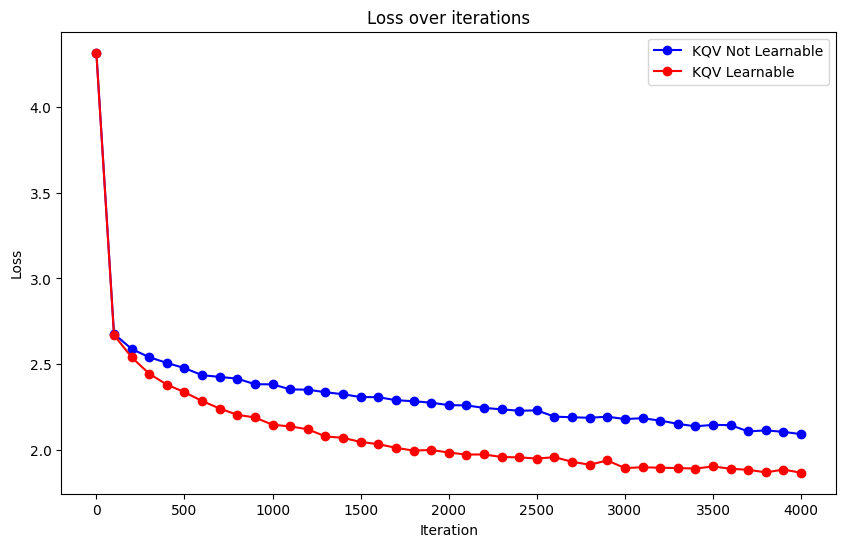

In [17]:
plot_loss(['KQV Not Learnable', 'KQV Learnable'], loss_hist_disable, loss_hist_enable)

As you can see, Key, Query and Value weights are pretty important for training a transformer language model with self-attention mechanism. Self-attention mechanism's only learnable parts are the K, Q, V weight matrices. Apart from that, self-attention mechansism has no learnable components.

The importance of self-attention mechansim with learnable K, Q, V weight matrices will be more apparent if the language model is a word level or sub-word level since it will have a huge vocab size.